# Imports

In [138]:
# Remember to login to wandb!
!wandb login ${WANDB_API}

import sys
import os 

# Add the test directory to sys.path
parent_dir = os.path.expanduser('..')
sys.path.append(parent_dir)



# Standard library imports
import importlib
import gc
import copy

# Third-party imports
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import einops
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate
import wandb


# Reload modules using importlib
importlib.reload(importlib.import_module('eigenestimation.eigenhora'))
importlib.reload(importlib.import_module('eigenestimation.loss'))
importlib.reload(importlib.import_module('eigenestimation.train'))
importlib.reload(importlib.import_module('evaluation.examples'))
importlib.reload(importlib.import_module('evaluation.networks'))

importlib.reload(importlib.import_module('toy_models.tms'))
importlib.reload(importlib.import_module('eigenestimation.utils'))



from eigenestimation.eigenhora import EigenHora
from eigenestimation import loss
from eigenestimation.train import Train
from evaluation.examples import TopActivatingSamples 
from evaluation.networks import DrawNeuralNetwork

from toy_models import tms
from eigenestimation.utils import TransformDataLoader, DeleteParams, RetrieveWandBArtifact

device = 'cuda'



wandb: Currently logged in as: brianna-chrisman (brianna-chrisman-2024). Use `wandb login --relogin` to force relogin


# TMS

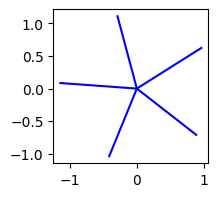

In [71]:
# Load TMS model
tms_model = tms.AutoencoderSymmetric(input_dim=5, hidden_dim=2)
tms_model.load_state_dict(torch.load(f"{parent_dir}/models/tms_model.pth", weights_only=True))

# Plot TMS representations.
en = copy.deepcopy(tms_model.W_in).detach().cpu().numpy().transpose()

plt.figure(figsize=(2,2))
for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'b-')
plt.show()

# Parallel TMS


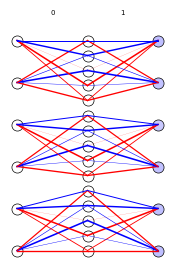

In [140]:
# Load TMS model
tms_model_p = tms.AutoencoderParallel(input_dim=5, hidden_dim=2, n_networks=3)
tms_model_p.load_state_dict(torch.load(f"{parent_dir}/models/tms_model_parallel.pth", weights_only=True))

model_params = dict(tms_model_p.named_parameters())
weights = {k:v for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

f = DrawNeuralNetwork(weights, biases)

In [141]:
def model0(y):
    return torch.zeros_like(y)

n_networks = 3

n_features = 5

n_datapoints = 3*4096
X_tms_p, _, _= tms.GenerateTMSDataParallel(
    num_features=n_features, num_datapoints=n_datapoints,
    sparsity=.05,
    batch_size=16,
    n_networks=n_networks)

X_tms_p = X_tms_p.to(device)

hora_features = 15
hora_rank = 1
eigenmodel = EigenHora(tms_model_p.to(device), model0, loss.MSELoss(), hora_features, hora_rank, device=device).to(device)


dataloader = TransformDataLoader(X_tms_p, batch_size=32, transform_fn=eigenmodel.compute_jacobian)


eval_dataloader = TransformDataLoader(X_tms_p[:1000], batch_size=32, transform_fn=eigenmodel.compute_jacobian)
Train(eigenmodel, dataloader, lr=.001, n_epochs=10, L0_penalty=.01, device=device, project_name='eigenestimation', run_name='tms_model_parallel',
      eval_fns={TopActivatingSamples:[3]}, eval_dataloader=eval_dataloader)    

Epoch 0 : 4.916,  Reconstruction Loss: 4.894,  Sparsity Loss: 2.180


Epoch 1 : 3.624,  Reconstruction Loss: 3.587,  Sparsity Loss: 3.794
Epoch 2 : 3.037,  Reconstruction Loss: 2.998,  Sparsity Loss: 3.940
Epoch 3 : 2.393,  Reconstruction Loss: 2.356,  Sparsity Loss: 3.753
Epoch 4 : 1.891,  Reconstruction Loss: 1.856,  Sparsity Loss: 3.484
Epoch 5 : 1.650,  Reconstruction Loss: 1.617,  Sparsity Loss: 3.244
Epoch 6 : 1.511,  Reconstruction Loss: 1.481,  Sparsity Loss: 3.037
Epoch 7 : 1.429,  Reconstruction Loss: 1.401,  Sparsity Loss: 2.879
Epoch 8 : 1.358,  Reconstruction Loss: 1.330,  Sparsity Loss: 2.740
Epoch 9 : 1.246,  Reconstruction Loss: 1.219,  Sparsity Loss: 2.602
evaluating...
TopActivatingSamples


reconstruction_loss,█▆▄▃▂▂▁▁▁▁
sparsity_loss,▁▇█▇▆▅▄▄▃▃
total_loss,█▆▄▃▂▂▂▁▁▁
reconstruction_loss,1.21949
sparsity_loss,2.60209
total_loss,1.24551


In [142]:
top_samples = RetrieveWandBArtifact(project_path="brianna-chrisman-2024/Eigenestimation/eigenestimation_tms_model_parallel", metric_name="TopActivatingSamples")



eigenmodel = EigenHora(tms_model_p, None, loss.MSELoss(), len(top_samples), 1, device=device).to(device)
eigenmodel.low_rank = RetrieveWandBArtifact(project_path="brianna-chrisman-2024/Eigenestimation/eigenestimation_tms_model_parallel", metric_name="subnetworks")

wandb:   1 of 1 files downloaded.  


/root/workspace/eigenestimation/notebooks/artifacts/eigenestimation_tms_model_parallel_TopActivatingSamples:v17


wandb:   1 of 1 files downloaded.  


/root/workspace/eigenestimation/notebooks/artifacts/eigenestimation_tms_model_parallel_subnetworks:v13


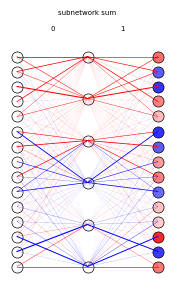

In [143]:
model_params = eigenmodel.reconstruct_network()
weights = {k:v.transpose(0,1) for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}


figs = DrawNeuralNetwork(weights, biases, title='subnetwork sum')

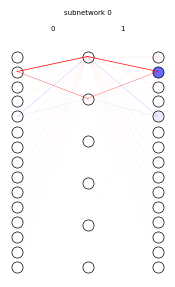

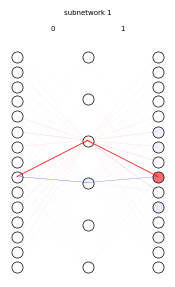

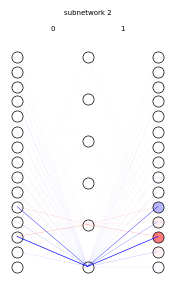

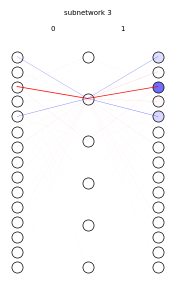

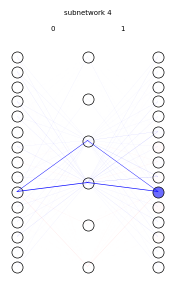

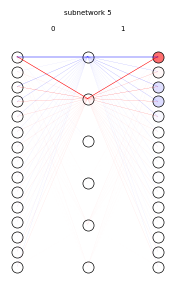

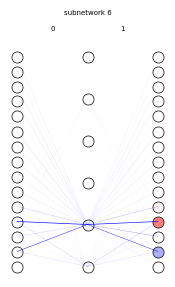

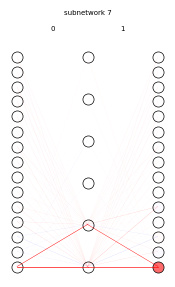

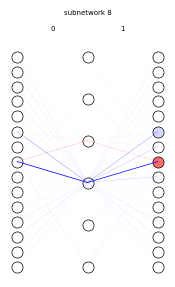

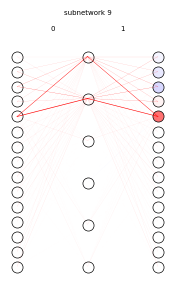

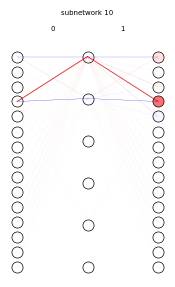

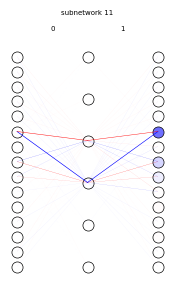

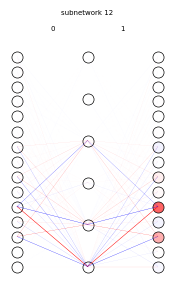

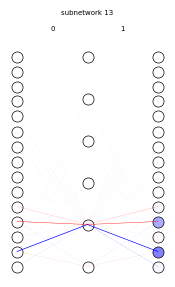

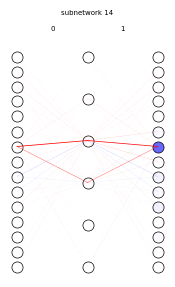

In [146]:
figs = []

for i, network in enumerate(eigenmodel.construct_subnetworks()):
    weights = {k:v.transpose(0,1) for k,v in network.items() if 'b' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}

    
    figs.append(DrawNeuralNetwork(weights, biases, title=f'subnetwork {i}'))

